# CLIP EVALUATION

<span style="color: white;">
Explanation: This notebook is dedicated to evaluating cloth samples <br> and classes using CLIP against various rotations, aiming to <br> identify confidence ranges as well as areas of uncertainty.
</span>


In [1]:
# %%capture
# %pip install ftfy regex tqdm matplotlib opencv-python scipy scikit-image
# %pip install git+https://github.com/openai/CLIP.git

**IMPORT**

In [50]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path
from src.pipeline.helper import get_all_samples
from src.utils.clip_grad_cam import *

import seaborn as sns
from sklearn.metrics import confusion_matrix

**LOAD DESIRED CLIP MODEL/ENCODER**

In [40]:
clip_model = "ViT-L/14" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/14", "ViT-B/16", "ViT-B/32"]

blur = True #@param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

100%|███████████████████████████████████████| 890M/890M [00:32<00:00, 28.8MiB/s]


**(1) PREDICT CLASS AGAINST INCREMENTAL ROTATIONS** <br>

Note: Counting correct samples per rotation account

In [73]:
confusion_matrix = np.zeros((7, 19))
conf = confusion_matrix[0]

saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]

classes = ['dress', 'jacket', 'shirt', 'tshirt', 'pant', 'short']

classes_prompt = [f'a photo of a {cl}' for cl in classes]

for k, cloth_class in enumerate(classes):

    search_index = k

    all_samples = get_all_samples(cloth_class)

    all_samples = all_samples[:20]

    for sample in all_samples:
        
        image = Image.open(sample[1])
        
        for i in range (0, 19):

            rot_image = image.rotate(10*i)

            image_input = preprocess(rot_image).unsqueeze(0).to(device)
            image_np = load_image(rot_image, model.visual.input_resolution)

            text = clip.tokenize(classes_prompt).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image_input)
                text_features = model.encode_text(text)

            # Pick the top 5 most similar labels for the image
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            values, indices = similarity[0].topk(6)

            # Update confusion matrix
            for value, index in zip(values, indices):
                    if index.item() == k:
                        confusion_matrix[k][i] += 1
                    break  # Break to count only the first match


**(1) PLOT RESULTS**

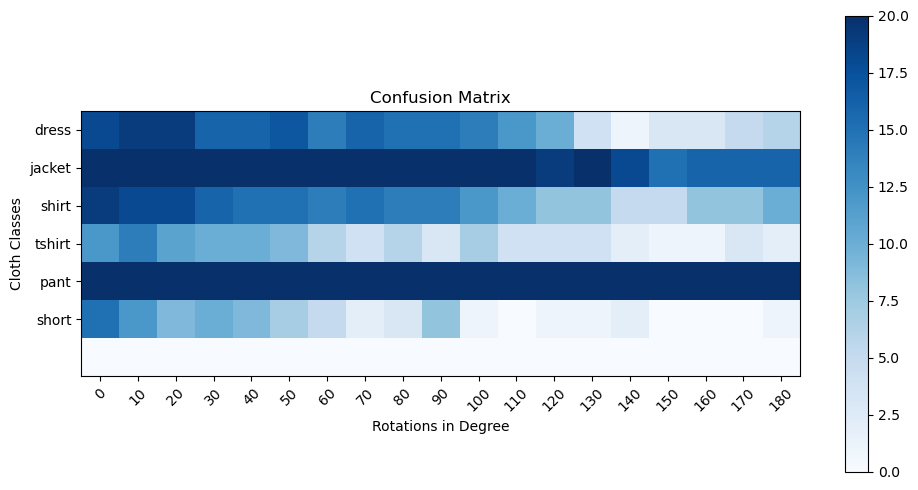

In [42]:
rotations = [i for i in np.arange(0, 190, 10)]
# Plot the confusion matrix with annotations
plt.figure(figsize=(10, 5))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(rotations)), rotations, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.ylabel('Cloth Classes')
plt.xlabel('Rotations in Degree')
plt.tight_layout()
plt.show()

**(2) PREDICT CLASS AGAINST INCREMENTAL ROTATIONS** <br>

Note: Counting correct samples per class

In [43]:
# Initialize confusion matrix
confusion_matrix = np.zeros((6, 6))

# Define the saliency layer
saliency_layer = "layer4"  # @param ["layer4", "layer3", "layer2", "layer1"]

# Define classes
classes = ['dress', 'jacket', 'shirt', 'tshirt', 'pant', 'short']
classes_prompt = [f'a photo of a {cl}' for cl in classes]

# Iterate through each class
for k, cloth_class in enumerate(classes):

    # Get all samples for the current class
    all_samples = get_all_samples(cloth_class)
    all_samples = all_samples[:20]

    for sample in all_samples:
        image = Image.open(sample[1])

        for i in range(19):  # Rotating the image
            rot_image = image.rotate(10 * i)

            # Preprocess the rotated image
            image_input = preprocess(rot_image).unsqueeze(0).to(device)
            image_np = load_image(rot_image, model.visual.input_resolution)

            # Tokenize the text
            text = clip.tokenize(classes_prompt).to(device)

            with torch.no_grad():
                # Encode image and text features
                image_features = model.encode_image(image_input)
                text_features = model.encode_text(text)

            # Normalize features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            
            # Compute similarity
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            values, indices = similarity[0].topk(6)

            # Update confusion matrix
            for value, index in zip(values, indices):
                    confusion_matrix[k][index.item()] += 1
                    break  # Break to count only the first match

# Print or further process the confusion matrix if needed
print(confusion_matrix)


[[223.   0.   8.   2. 120.  27.]
 [  0. 360.   0.   0.  19.   1.]
 [  6.  80. 232.   0.  52.  10.]
 [ 23.   6. 188. 113.  26.  24.]
 [  0.   0.   0.   0. 380.   0.]
 [  0.  10.   0.   0. 284.  86.]]


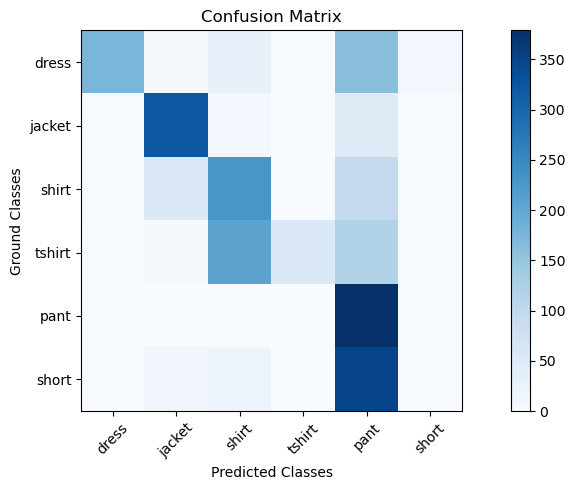

In [38]:
# Plot the confusion matrix with annotations
plt.figure(figsize=(10, 5))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.ylabel('Ground Classes')
plt.xlabel('Predicted Classes')
plt.tight_layout()
plt.show()